1. 記述子の選択
2. アルゴリズムの選択
3. dbから予測データを取得
4. ADの適用範囲を調査

In [1]:
import pandas as pd

In [19]:
df = pd.read_csv('database_1114.csv')
print(df.columns)

Index(['entry', 'R1-', 'R2', 'organocatalyst', 'organocatalyst(mol%)', 'under',
       'temp(℃)', 'time(h)', 'Cu(OAc)2(mol%)', 'AcOH(mol%)', '収率(%)'],
      dtype='object')


In [20]:
# 基質、触媒、収率で欠損がある場合は削除
df.dropna(subset=['R1-', 'R2', 'organocatalyst', '収率(%)'], inplace=True)

In [21]:
print('欠損値合計', df.isnull().sum())
na_row = df.isnull().any(axis=1)
df.loc[na_row, :]

欠損値合計 entry                   0
R1-                     0
R2                      0
organocatalyst          0
organocatalyst(mol%)    0
under                   0
temp(℃)                 0
time(h)                 0
Cu(OAc)2(mol%)          0
AcOH(mol%)              0
収率(%)                   0
dtype: int64


,entry,R1-,R2,organocatalyst,organocatalyst(mol%),under,temp(℃),time(h),Cu(OAc)2(mol%),AcOH(mol%),収率(%)


In [28]:
# R2, underはカテゴリ値で置く
# 念の為確認。
[print(df[name].value_counts()) for name in df.columns if name in ['R2', 'under']]

H     101
C      61
Ph      3
Name: R2, dtype: int64
O2     111
air     53
Ar       1
Name: under, dtype: int64


[None, None]

In [32]:
#カテゴリ値に変換
df = pd.get_dummies(df, columns=['R2','under'])
df.head(5)

KeyError: "None of [Index(['R2', 'under'], dtype='object')] are in the [columns]"

In [79]:
# tempの「rt」を23℃に変換
df['temp(℃)'][df['temp(℃)'] == 'rt'] = 23
print(df['temp(℃)'] == 'rt')

0      False
1      False
2      False
3      False
4      False
       ...  
206    False
207    False
208    False
209    False
212    False
Name: temp(℃), Length: 165, dtype: bool


/var/folders/12/6r_lrg9d6kx949nw6gcq9ksh0000gn/T/ipykernel_93936/2666549685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp(℃)'][df['temp(℃)'] == 'rt'] = 23


In [215]:
check_columns = df.columns.drop(['entry', '収率(%)'])

# 説明変数のみでみた時の重複削除
_df = df.drop(columns='entry').drop_duplicates(subset=check_columns).reset_index(drop=True)
X = _df.drop(columns=['収率(%)'])
y = _df['収率(%)']
_df.to_csv('exec_1114_前処理後.csv')

In [497]:
# 説明変数をスケーリング
# 目的変数は必要ない。
# https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re
from sklearn.preprocessing import StandardScaler
scaling_columns = ['organocatalyst(mol%)','temp(℃)','time(h)','Cu(OAc)2(mol%)', 'AcOH(mol%)']
scaler = StandardScaler()
scaler.fit(X[scaling_columns])
X_scaled = pd.concat([X.drop(columns=scaling_columns), 
                           pd.DataFrame(scaler.transform(X[scaling_columns]),index=X.index , columns=scaling_columns)],
                           axis=1, join='inner')

print(X_scaled.shape)

(154, 13)


# 記述子の選定
1. 全てのパラメータを用いる。
   基質R1と触媒の化学構造をmorgan記述子に変換する。
2. 基質R1,R2と触媒のデータのみ用いる。(重複は削除)
3. 類似度(基質と触媒のMorgan記述子に基づいて計算したタニモト係数)とR2
4. DFTから出す？？？

In [498]:
X_scaled.columns

Index(['R1-', 'organocatalyst', 'R2_C', 'R2_H', 'R2_Ph', 'under_Ar',
       'under_O2', 'under_air', 'organocatalyst(mol%)', 'temp(℃)', 'time(h)',
       'Cu(OAc)2(mol%)', 'AcOH(mol%)'],
      dtype='object')

In [499]:
BIT = 2048

In [500]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

def toFinger(df, columns):
    df_copy = df.drop(columns=columns)
    for column in columns:
        fingerprints = toFingerFromSmiles(df[column])
        column_names = list(map(lambda x: str(x)+'_'+column, range(BIT)))
        df_copy = pd.merge(df_copy, pd.DataFrame(fingerprints,index=df.index, columns=column_names), left_index=True, right_index=True)
    return df_copy

def toFingerFromSmiles(series):
    mols = []
    for smile in series:
        if smile in ['-', 0]: smile = '' 
        mols.append(Chem.MolFromSmiles(smile))

    fingerprints = []
    for mol_idx, mol in enumerate(mols):
        try:
            # listに直してる。
            fingerprint = [x for x in Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,BIT)]
            fingerprints.append(fingerprint)
        except Exception as e:
            print("Error", mol_idx)
            break
    return fingerprints
del list

In [505]:
# 1. 全てのデータを使用
finger_columns = ['R1-', 'organocatalyst']
X_1 = toFinger(X_scaled, finger_columns)
y_1 = y

In [506]:
display(X_1.head(5))

,R2_C,R2_H,R2_Ph,under_Ar,under_O2,under_air,organocatalyst(mol%),temp(℃),time(h),Cu(OAc)2(mol%),...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
0,0,1,0,0,1,0,-0.448669,1.318053,-0.306406,-0.27155,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,-0.448669,1.318053,-0.934163,-0.27155,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,-0.448669,1.318053,-0.306406,-0.27155,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,-0.448669,1.318053,-0.934163,-0.27155,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,-0.448669,1.318053,-0.306406,-0.27155,...,0,0,0,0,0,0,0,0,0,0


In [507]:
# 基質R1,R2と触媒のデータのみ用いる。(重複は削除)
drop_columns = ['under_Ar', 'under_O2', 'under_air', 'organocatalyst(mol%)', 'temp(℃)', 'time(h)','Cu(OAc)2(mol%)', 'AcOH(mol%)']

X_1_dropped = X_1.drop(columns=drop_columns)

dataset_2 = pd.concat([X_1_dropped, y], axis=1)
dataset_2.drop_duplicates(subset=X_1_dropped.columns, inplace=True)
print('trainのduplicated: ', dataset_2.duplicated().value_counts())
X_2 = train_2.drop(columns=['収率(%)'])
y_2 = train_2['収率(%)']

trainのduplicated:  False    113
dtype: int64


In [508]:
display('X_2: ', X_train_2.head(3))
display('y_2: ', X_test_2.head(3))

'X_2: '

,R2_C,R2_H,R2_Ph,0_R1-,1_R1-,2_R1-,3_R1-,4_R1-,5_R1-,6_R1-,...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
19,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'y_2: '

,R2_C,R2_H,R2_Ph,0_R1-,1_R1-,2_R1-,3_R1-,4_R1-,5_R1-,6_R1-,...,2038_organocatalyst,2039_organocatalyst,2040_organocatalyst,2041_organocatalyst,2042_organocatalyst,2043_organocatalyst,2044_organocatalyst,2045_organocatalyst,2046_organocatalyst,2047_organocatalyst
26,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [591]:
# 類似性(基質と触媒のMorgan記述子に基づいて計算したタニモト係数)をxに追加
def toTanimoto(series, suffix):
    mols = []
    for smile in series:
        if smile in ['-', 0]: smile = '' 
        mols.append(Chem.MolFromSmiles(smile))

    fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,BIT) for mol in mols]
    column_names = [str(i)+'-'+suffix for i in range(len(fps))]
    return pd.DataFrame([DataStructs.BulkTanimotoSimilarity(fp, fps) for fp in fps], columns=column_names)

method_3_selected = ['R1-', 'organocatalyst', 'R2_C', 'R2_H', 'R2_Ph']
dataset_3 = pd.concat([X, y], axis=1)[method_3_selected + ['収率(%)']]
dataset_3 = dataset_3.drop_duplicates(subset=method_3_selected).reset_index(drop=True)

X_3 = pd.concat([toTanimoto(dataset_3['R1-'],'R1'), toTanimoto(dataset_3['organocatalyst'], 'organocatalyst'), dataset_3[['R2_C','R2_H','R2_Ph']]], axis=1)
y_3 = dataset_3['収率(%)']

In [593]:
display(X_3)
display(y_3)

,0-R1,1-R1,2-R1,3-R1,4-R1,5-R1,6-R1,7-R1,8-R1,9-R1,...,108-organocatalyst,109-organocatalyst,110-organocatalyst,111-organocatalyst,112-organocatalyst,113-organocatalyst,114-organocatalyst,R2_C,R2_H,R2_Ph
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.073171,0.073171,0.073171,0.073171,0.073171,0.073171,0.073171,0,1,0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0,1,0
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.175000,0.175000,0.175000,0.175000,0.175000,0.175000,0.175000,0,1,0
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.170732,0.170732,0.170732,0.170732,0.170732,0.170732,0.170732,0,1,0
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,0.129032,0.129032,0.129032,0.129032,0.129032,0.129032,0.129032,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.363636,0.260870,0.285714,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,0
111,0.315789,0.315789,0.315789,0.315789,0.315789,0.315789,0.315789,0.315789,0.411765,0.466667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,0
112,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.583333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,1
113,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.250000,0.352941,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,0


0      81.0
1      74.0
2      90.0
3      88.0
4      33.0
       ... 
110    89.0
111    99.0
112    96.0
113    83.0
114    99.0
Name: 収率(%), Length: 115, dtype: float64

# モデルの定義
- PLS

  多重共線性。寄与率見れる。
  相関関係がある複数の予測子変数が含まれているデータに用いる

- LASSO

  残差二乗和に罰則項を設け、過剰適合を防ぐ
  
- SVR

  説明変数を非線形変換した後の「特徴量空間」の中で誤差を少なくする。 => カーネル関数を用いて類似度を測定している。
  精度が高い
  
- GPR
  
- RF

  ブースティングを使ったアンサンブル決定木、精度が高い、結果がわかりやすい。
  
- GBDT

  勾配ブースティング
  
- XGB

外側3-fold-CV、内側に5-fold-CVを用いたダブルクロスバリデーションでモデルを選定した。

In [512]:
from sklearn.model_selection import KFold,GridSearchCV,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


In [536]:
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)


In [549]:
def predict_easy(X,y, param_grid, estimator):
    inner_cv = KFold(3, shuffle=True, random_state=0)
    outer_cv = KFold(5, shuffle=True, random_state=0)

    # cross-validation
    gsv_dcv = GridSearchCV(estimator, param_grid, cv=inner_cv)

    score_funcs = {
            'r2': make_scorer(r2_scorer),
            'rmse': make_scorer(rmse_scorer),
            'mae': make_scorer(mae_scorer),
        }

    scores = cross_validate(gsv_dcv, X, y, cv=outer_cv, scoring=score_funcs)
    display(pd.DataFrame(scores))
    return scores

In [691]:
def predict_score(X,y,param_grid, estimator):
    df = pd.concat([X,y],axis=1)
    # グリッドサーチのスコア、グリッドサーチの最適モデル、yの予測値、yの観測値、最適モデルでのR2,RMSE,MAEをそれぞれ定義する
    results = {
        'gs_scores': [],
        'best_estimators': [],
        'df_y_train_preds': pd.DataFrame(),
        'df_y_train_reals': pd.DataFrame(),
        'df_y_preds': pd.DataFrame(),
        'df_y_reals': pd.DataFrame(),
        'r2_preds': [],
        'r2': [],
        'rmse': [],
        'mae': [],
    }

    # 外側と内側のCVの分割数を定義する
    outer_cv = 5
    inner_cv = 3

    # 外側のクロスバリデーションをKFoldで設定する（5分割する）
    kfold = KFold(n_splits = outer_cv)
    for train, test in kfold.split(df):
        X_train = df.iloc[train,:-1]
        y_train = df.iloc[train, -1]
        X_test = df.iloc[test,:-1]
        y_test = df.iloc[test, -1]

        # 内側のクロスバリデーションをGridSearchCVで設定する（4分割する）
        gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="r2", cv=inner_cv, return_train_score=True)
        gs.fit(X=X_train, y=y_train)
        gs_score = gs.best_score_
        results['gs_scores'].append(gs_score)
        best_estimator = gs.best_estimator_
        print(best_estimator)
        results['best_estimators'].append(best_estimator)
        y_train_pred = best_estimator.predict(X_train)
        results['df_y_train_preds'] = pd.concat([results['df_y_train_preds'], pd.DataFrame(y_train_pred)])
        results['df_y_train_reals'] = pd.concat([results['df_y_train_reals'], y_train])
        y_pred = best_estimator.predict(X_test)
        results['df_y_preds'] = pd.concat([results['df_y_preds'], pd.DataFrame(y_pred)])
        results['df_y_reals'] = pd.concat([results['df_y_reals'], y_test])
        # 構築したモデルのスコア
        results['r2_train'].append(r2_scorer(y_train, y_train_pred))
        results['r2'].append(r2_scorer(y_test,y_pred))
        results['rmse'].append(rmse_scorer(y_test, y_pred))
        results['mae'].append(mae_scorer(y_test,y_pred))
    return results

In [ ]:
def func(estimator=a):
    print(a*2)

In [664]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "DejaVu Serif"

def yyplot(y_obs, y_pred, title):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('Real Y', fontsize=24)
    plt.ylabel('Predicted Y', fontsize=24)
    plt.title(title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def plot_result(results, method, estimator):
    title = f'{method} estimator {estimator}'
    yyplot(results['df_y_reals'].values, results['df_y_preds'].values, title)
    columns=['r2_train', 'r2', 'rmse', 'mae']
    
    result = pd.DataFrame([results['r2'], results['r2'], results['rmse'], results['mae']]).T.set_axis(columns, axis='columns').mean()
    result.name = method
    return result

In [599]:
each_method_dataset = {
    'method1': [X_1, y_1],
    'method2': [X_2, y_2],
    'method3': [X_3, y_3],
}

method1
SVR(C=10)
SVR(C=10)
SVR(C=1)
SVR(C=1)
SVR(C=10)


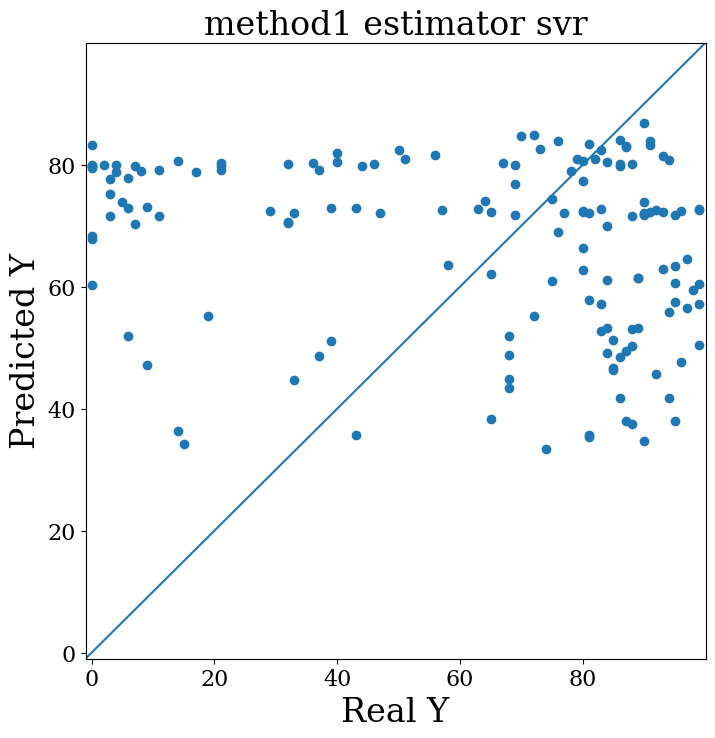

[r2      -0.823552
rmse    38.231887
mae     32.073778
Name: method1, dtype: float64]
method2
SVR(C=10)
SVR(C=10)
SVR(C=10)
SVR(C=10)
SVR(C=10)


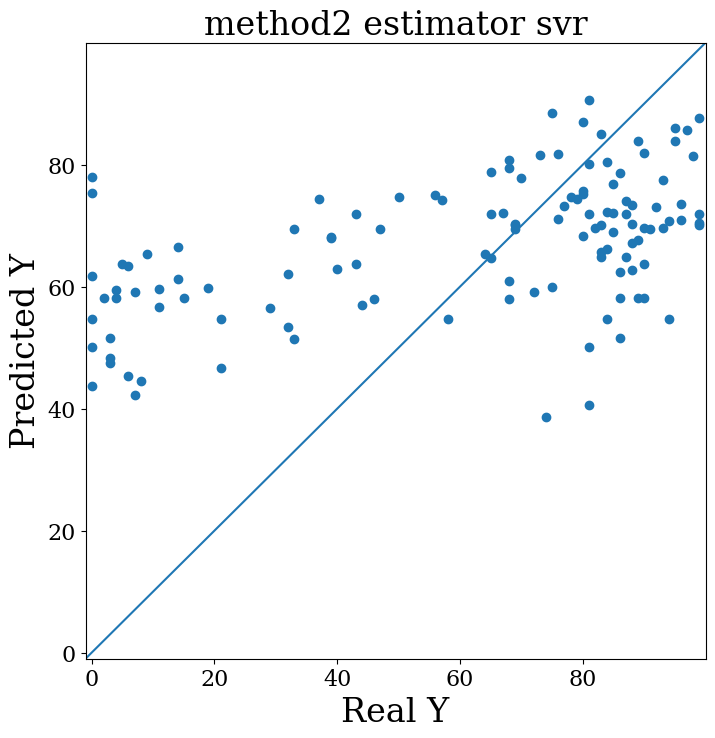

[r2      -0.823552
rmse    38.231887
mae     32.073778
Name: method1, dtype: float64, r2       0.185876
rmse    29.256045
mae     23.780069
Name: method2, dtype: float64]
method3
SVR(C=10)
SVR(C=10)
SVR(C=1)
SVR(C=1)
SVR(C=1)


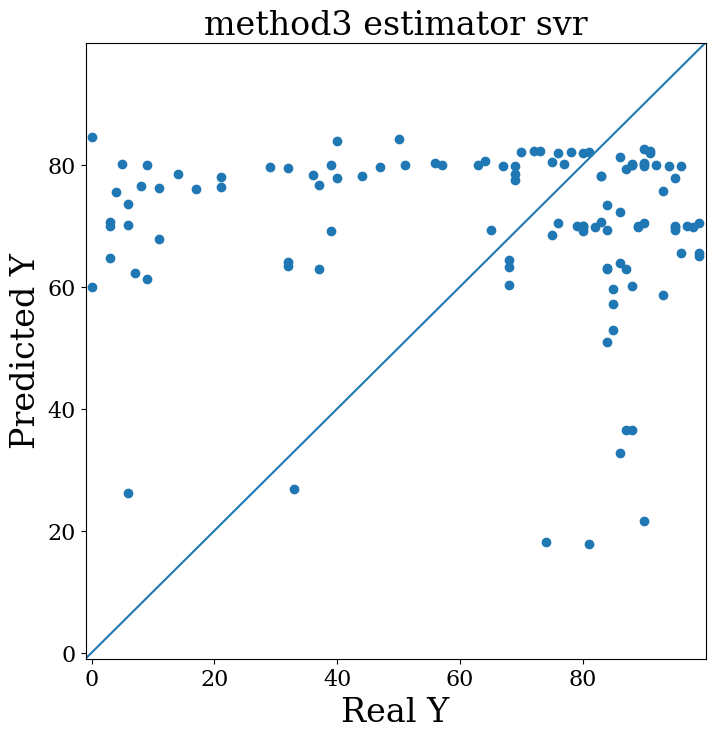

[r2      -0.823552
rmse    38.231887
mae     32.073778
Name: method1, dtype: float64, r2       0.185876
rmse    29.256045
mae     23.780069
Name: method2, dtype: float64, r2      -1.170402
rmse    34.151309
mae     28.084384
Name: method3, dtype: float64]


,method1,method2,method3
r2,-0.823552,0.185876,-1.170402
rmse,38.231887,29.256045,34.151309
mae,32.073778,23.780069,28.084384


In [667]:
# svr
from sklearn import svm
# ハイパーパラメータ: https://qiita.com/oki_kosuke/items/a09878562a0c87b217c2
C_range = list(2 ** np.arange(-5, 11, dtype=float))
epsilon_range = list(2 ** np.arange(-10, 1, dtype=float))
gamma_range = list(2 ** np.arange(-20, 11, dtype=float))
param_grid = {"C":C_range, "epsilon":epsilon_range, "gamma":gamma_range}
param_grid = {"C": [1,10]}

svr = svm.SVR(kernel="rbf")

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, svr)
    score = plot_result(results, method, 'svr')
    scores.append(score)
display(pd.concat(scores,axis=1))

method1
RandomForestRegressor(max_features=None, n_estimators=10)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=10)
RandomForestRegressor(max_depth=5, max_features='log2')
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=200)
RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=300)


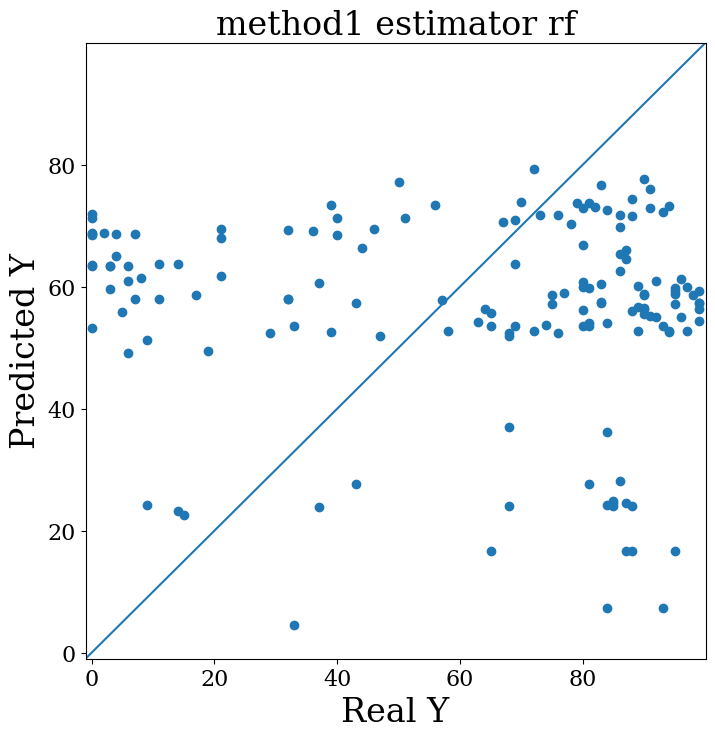

[r2      -0.823552
rmse    38.231887
mae     32.073778
Name: method1, dtype: float64, r2       0.185876
rmse    29.256045
mae     23.780069
Name: method2, dtype: float64, r2      -1.170402
rmse    34.151309
mae     28.084384
Name: method3, dtype: float64, r2      -0.873417
rmse    37.958134
mae     33.074518
Name: method1, dtype: float64]
method2
RandomForestRegressor(max_features='log2', n_estimators=200)
RandomForestRegressor(max_depth=50, max_features='log2', n_estimators=300)
RandomForestRegressor(max_depth=5, max_features=None, n_estimators=200)
RandomForestRegressor(max_depth=5, max_features='sqrt')
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300)


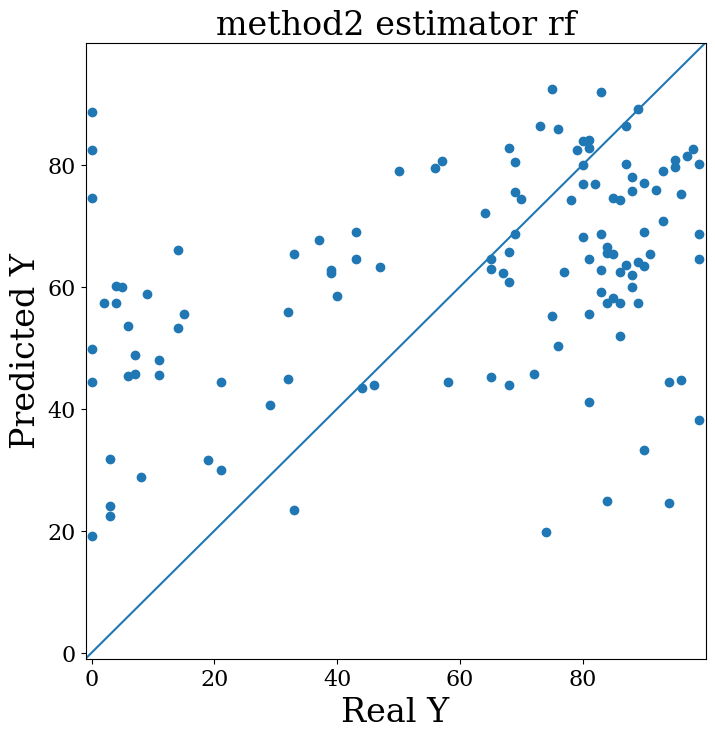

[r2      -0.823552
rmse    38.231887
mae     32.073778
Name: method1, dtype: float64, r2       0.185876
rmse    29.256045
mae     23.780069
Name: method2, dtype: float64, r2      -1.170402
rmse    34.151309
mae     28.084384
Name: method3, dtype: float64, r2      -0.873417
rmse    37.958134
mae     33.074518
Name: method1, dtype: float64, r2       0.126531
rmse    30.151105
mae     24.252322
Name: method2, dtype: float64]
method3
RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=10)
RandomForestRegressor(max_depth=50, max_features='log2', n_estimators=200)
RandomForestRegressor(max_depth=50, max_features='log2', n_estimators=10)
RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=10)
RandomForestRegressor(max_features='log2', n_estimators=10)


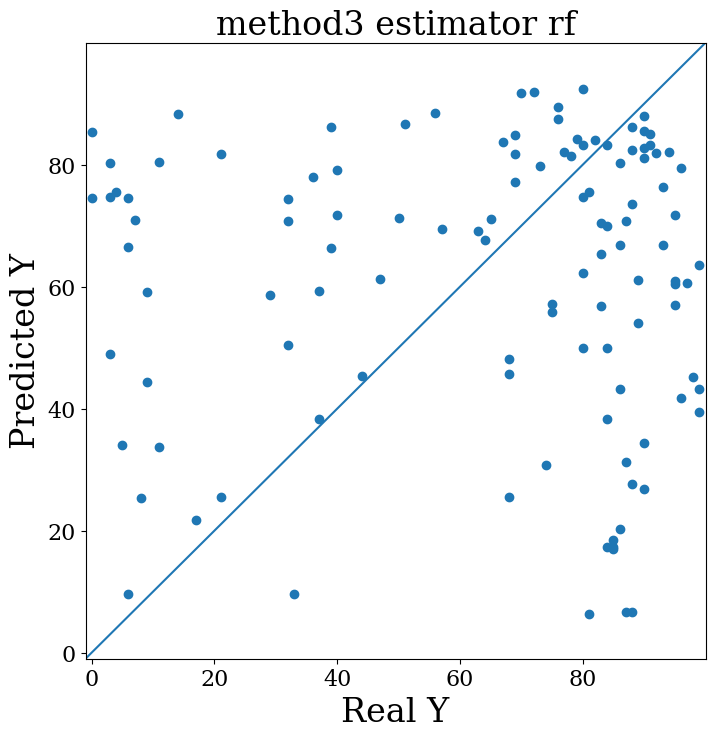

[r2      -0.823552
rmse    38.231887
mae     32.073778
Name: method1, dtype: float64, r2       0.185876
rmse    29.256045
mae     23.780069
Name: method2, dtype: float64, r2      -1.170402
rmse    34.151309
mae     28.084384
Name: method3, dtype: float64, r2      -0.873417
rmse    37.958134
mae     33.074518
Name: method1, dtype: float64, r2       0.126531
rmse    30.151105
mae     24.252322
Name: method2, dtype: float64, r2      -2.591487
rmse    37.054860
mae     30.758082
Name: method3, dtype: float64]


,method1,method2,method3,method1,method2,method3
r2,-0.823552,0.185876,-1.170402,-0.873417,0.126531,-2.591487
rmse,38.231887,29.256045,34.151309,37.958134,30.151105,37.054860
mae,32.073778,23.780069,28.084384,33.074518,24.252322,30.758082


In [668]:
# rf
from sklearn.ensemble import RandomForestRegressor
# ハイパーパラメータ:https://tatsu-mk2.hatenablog.jp/entry/2019/05/04/185733
rf = RandomForestRegressor()
param_grid = {'n_estimators':[10, 100, 200, 300], 'max_depth':[5, 10, 50, None], 'max_features': ["sqrt", "log2", None]}
scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, rf)
    score = plot_result(results, method, 'rf')
    scores.append(score)
display(pd.concat(scores,axis=1))

method1
PLSRegression(max_iter=1000, n_components=5, scale=False)
PLSRegression(max_iter=1000)
PLSRegression(max_iter=1000, n_components=3)
PLSRegression(max_iter=1000)
PLSRegression(max_iter=1000)


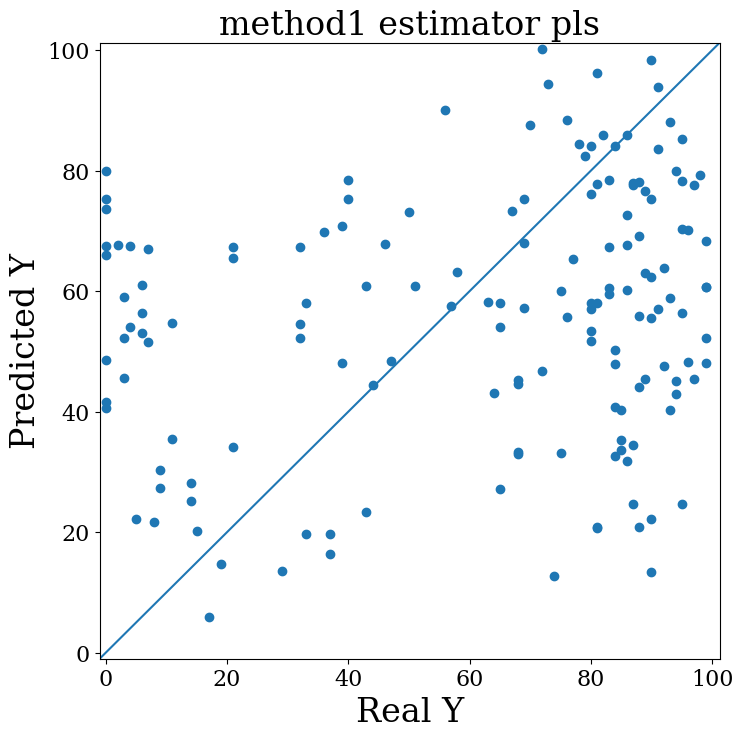

method2
PLSRegression(max_iter=1000, scale=False)
PLSRegression(max_iter=1000, scale=False)
PLSRegression(max_iter=1000, n_components=3, scale=False)
PLSRegression(max_iter=1000, n_components=3, scale=False)
PLSRegression(max_iter=1000, scale=False)


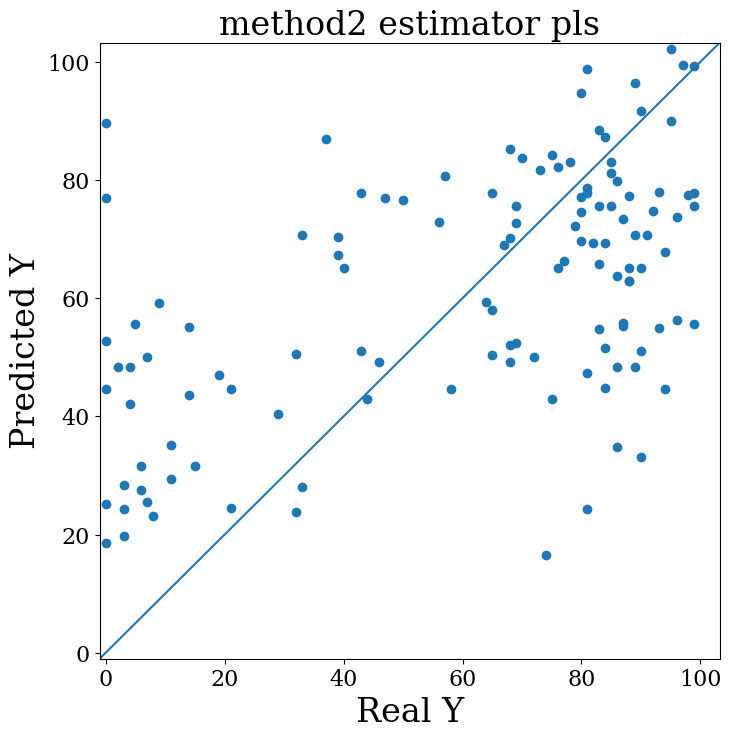

method3
PLSRegression(max_iter=1000, scale=False)
PLSRegression(max_iter=1000, scale=False)
PLSRegression(max_iter=1000, scale=False)
PLSRegression(max_iter=1000, n_components=5)
PLSRegression(max_iter=1000, n_components=4, scale=False)


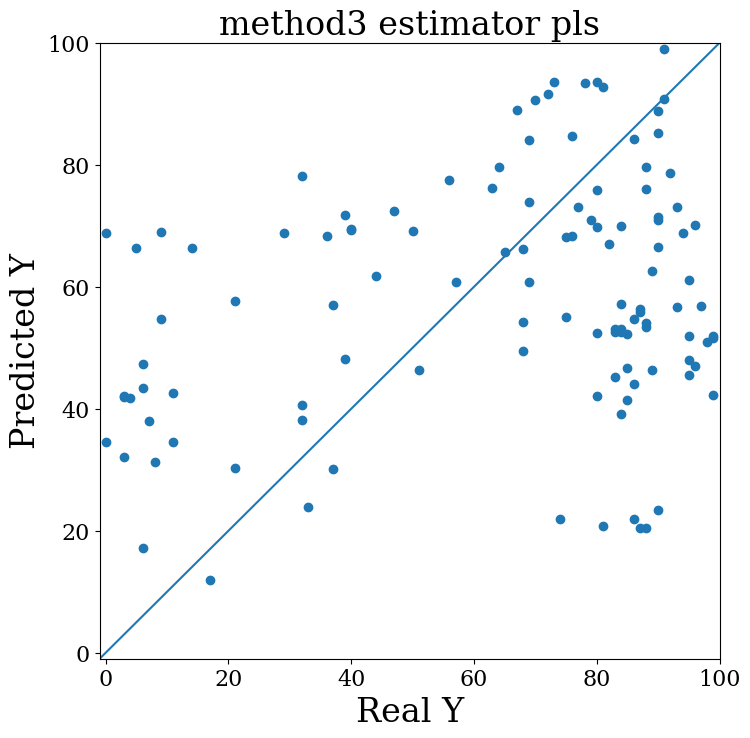

,method1,method2,method3
r2,-0.613028,0.266981,-2.335156
rmse,34.951715,27.572428,31.774152
mae,29.426180,22.191667,27.261446


In [692]:
# PLS
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression()
param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [1000]}

scores = []
pls_results = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, pls)
    pls_results.append(results)
    score = plot_result(results, method, 'pls')
    scores.append(score)
display(pd.concat(scores,axis=1))

In [695]:
r2_scorer(pls_results[0]['df_y_train_preds'], pls_results[0]['df_y_train_reals'])

0.42918928478955554

method1


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.948e+02, tolerance: 9.015e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.908e+02, tolerance: 9.054e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.948e+02, tolerance: 9.015e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e+03, tolerance: 6.164e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=100, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.337e+02, tolerance: 1.028e+01
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.430e+02, tolerance: 7.534e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=100, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e+03, tolerance: 7.448e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.612e+02, tolerance: 6.590e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=10, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.398e+02, tolerance: 9.265e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.623e+03, tolerance: 9.533e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=100, max_iter=10000)


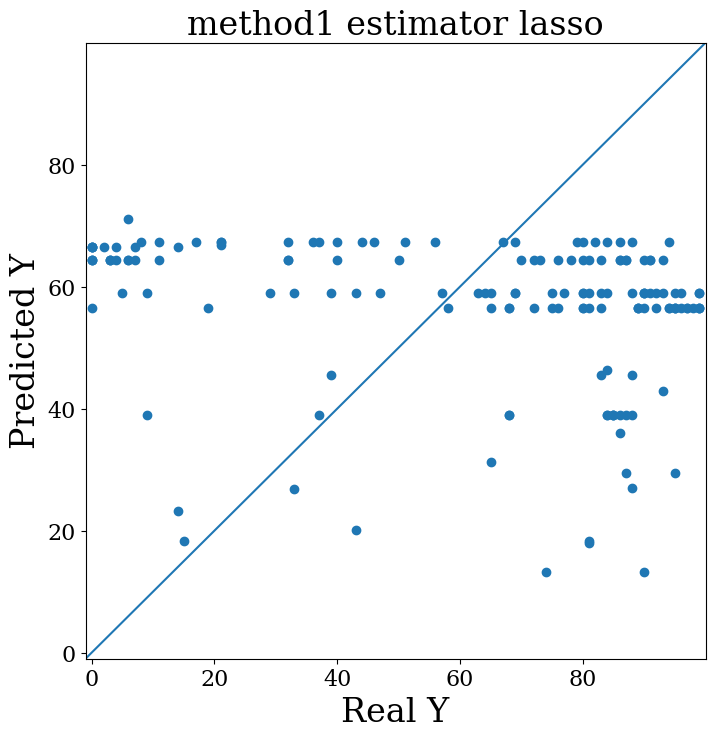

method2


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+03, tolerance: 7.764e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+03, tolerance: 6.429e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+03, tolerance: 7.764e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+02, tolerance: 5.432e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+03, tolerance: 7.771e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.682e+02, tolerance: 5.230e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+03, tolerance: 7.900e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.216e+02, tolerance: 5.755e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+03, tolerance: 8.629e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e+03, tolerance: 6.491e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


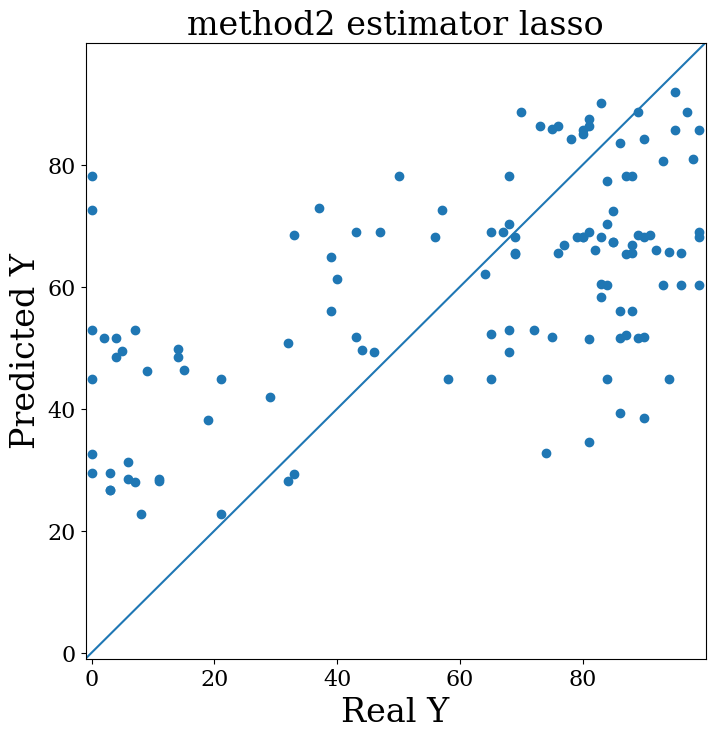

method3


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.036e+01, tolerance: 4.811e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.925e+02, tolerance: 6.741e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=1, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.036e+01, tolerance: 4.811e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.886e+02, tolerance: 3.358e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=10, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+02, tolerance: 7.118e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.574e+02, tolerance: 3.977e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=10, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+02, tolerance: 6.474e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+02, tolerance: 3.653e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=10, max_iter=10000)


/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+02, tolerance: 6.447e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e+02, tolerance: 5.245e+00
  model = cd_fast.enet_coordinate_descent(
/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso(alpha=10, max_iter=10000)


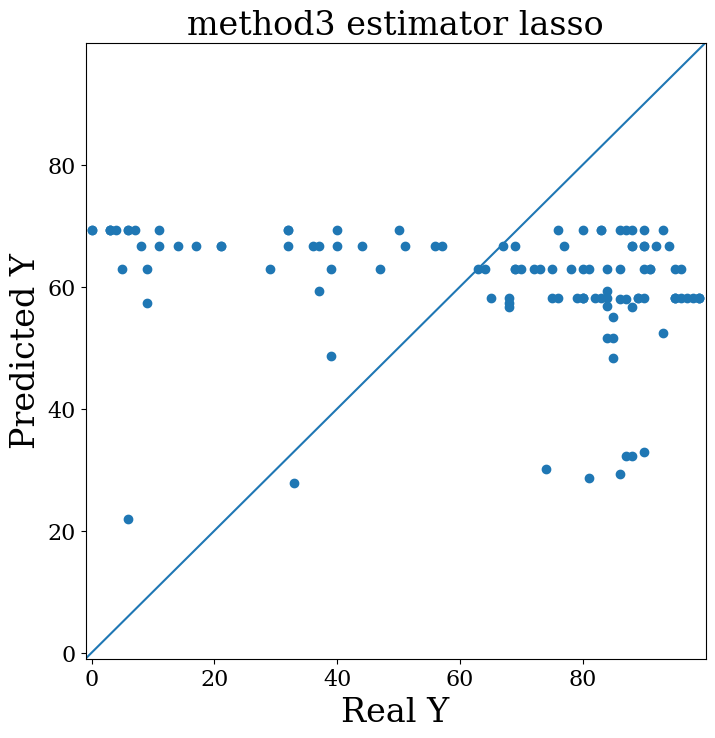

,method1,method2,method3
r2,-0.828777,0.346566,-1.990616
rmse,37.776276,26.060404,34.162449
mae,33.483498,21.747539,30.032630


In [673]:
# LASSO
from sklearn.linear_model import Lasso
# ハイパーパラメータ:https://qiita.com/damyarou/items/10a43358a96ed5d13832
lasso = Lasso()
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]}

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, lasso)
    score = plot_result(results, method, 'lasso')
    scores.append(score)
display(pd.concat(scores,axis=1))

method1
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor(max_depth=5, n_estimators=20)
GradientBoostingRegressor(learning_rate=0.2)
GradientBoostingRegressor(n_estimators=20)


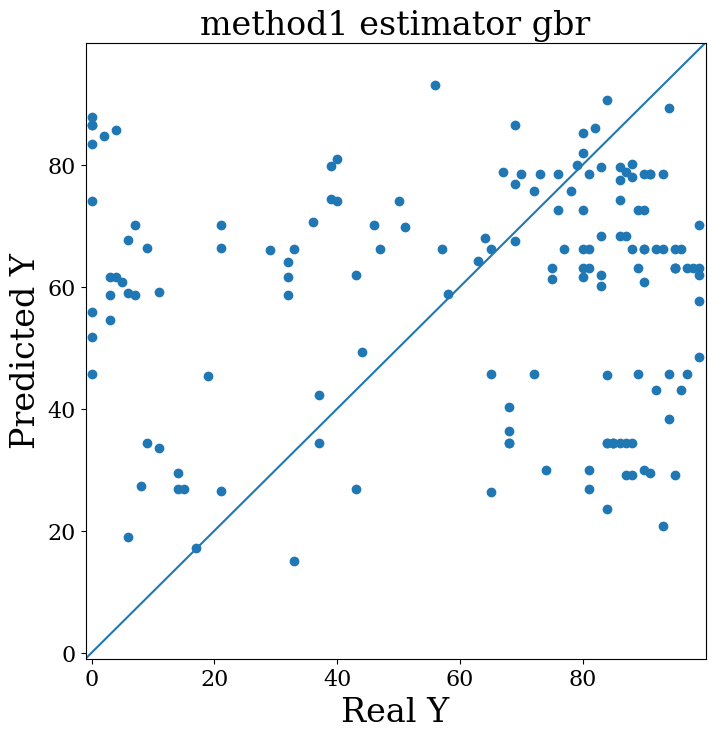

method2
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor()
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor(n_estimators=20)


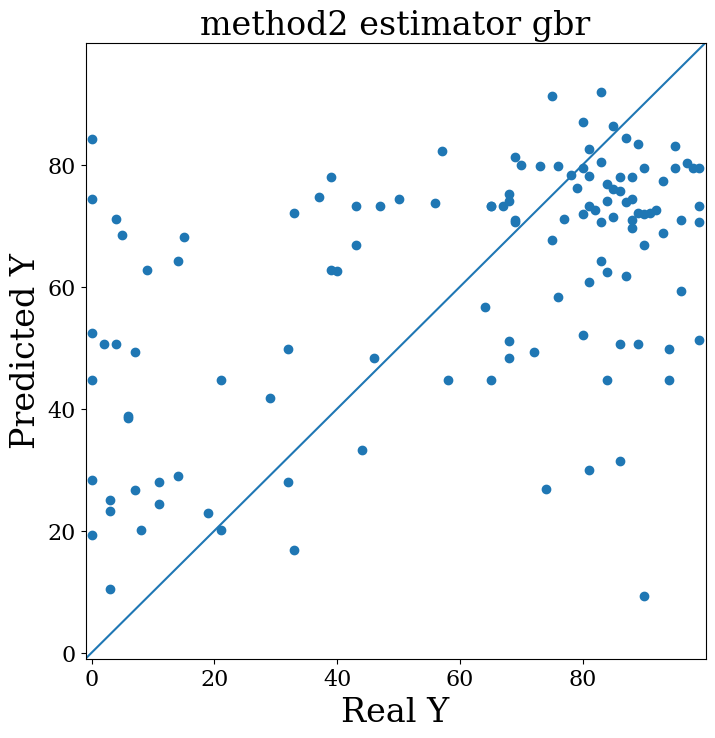

method3
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor(max_depth=5)
GradientBoostingRegressor(n_estimators=20)
GradientBoostingRegressor(max_depth=5, n_estimators=20)
GradientBoostingRegressor(n_estimators=20)


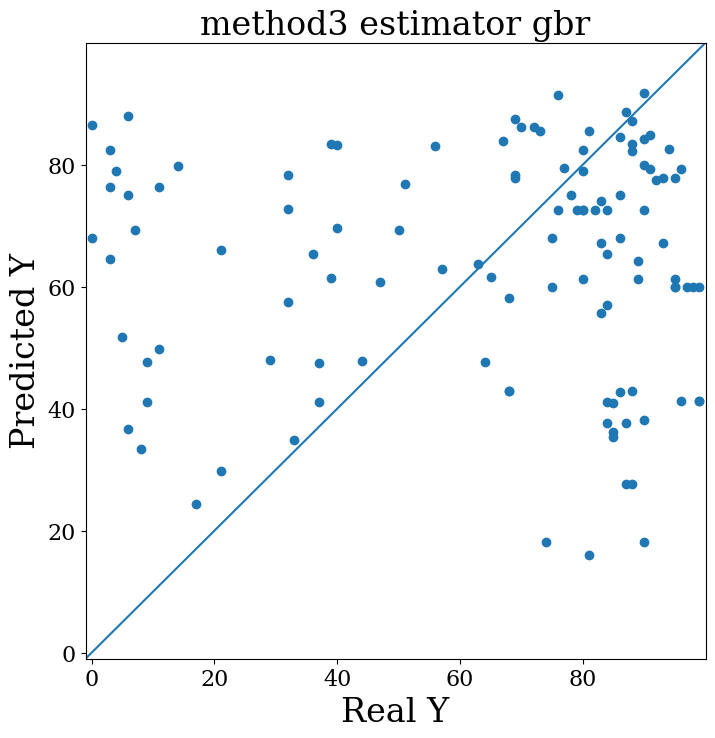

,method1,method2,method3
r2,-0.801916,0.260652,-2.063414
rmse,37.273878,27.732357,34.221151
mae,30.767492,21.886634,28.126925


In [675]:
# 勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor

# ハイパーパラメータ:https://qiita.com/maskot1977/items/c648e398b3b86cb68ae5
gbr = GradientBoostingRegressor()
param_grid = [{
    'learning_rate':[0.1,0.2],
    'n_estimators':[20,100],
    'max_depth':[3,5]
}]

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_score(* xy, param_grid, gbr)
    score = plot_result(results, method, 'gbr')
    scores.append(score)
display(pd.concat(scores,axis=1))

In [ ]:
GPR
GBDT
XGB

In [678]:
pls = PLSRegression()
param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [1000]}

scores = []
for method, xy in each_method_dataset.items():
    print(method)
    results = predict_easy(* xy, param_grid, pls)
    print(results)
    score = plot_result(results, method, 'pls')
    scores.append(score)
display(pd.concat(scores,axis=1))

method1


,fit_time,score_time,test_r2,test_rmse,test_mae
0,2.782113,0.033060,0.205021,29.957313,24.374546
1,3.044390,0.038563,-0.074639,27.038096,20.261990
2,3.602692,0.038709,0.328199,28.906201,23.682319
3,2.938924,0.035785,0.368226,29.059097,25.856481
4,3.224838,0.038554,0.425645,23.645946,17.295363


{'fit_time': array([2.78211308, 3.0443902 , 3.60269213, 2.93892407, 3.22483778]), 'score_time': array([0.03305984, 0.03856277, 0.03870893, 0.03578496, 0.03855419]), 'test_r2': array([ 0.20502146, -0.07463894,  0.32819866,  0.36822619,  0.42564499]), 'test_rmse': array([29.95731309, 27.03809614, 28.90620128, 29.05909692, 23.64594619]), 'test_mae': array([24.37454577, 20.2619902 , 23.68231922, 25.85648095, 17.29536312])}


KeyError: 'best_estimators'